In [39]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm


from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar

# **Исследование данных HR-агентства**

HR-агентство изучает тренды на рынке труда в *IT*. Компания хочет провести исследование на основе данных о зарплатах в сфере *Data Science* за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:  
2.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?  
2.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?  
2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?  
2.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [40]:
data = pd.read_csv('D:/Skillfactory/data/ds_salaries.csv')
display(data)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## **1. Какие факторы влияют на зарплату специалиста Data Scientist**

Возьмём страны соискателей (employee_residence) и посмотрим соотношение зарплаты в долларах США (salary_in_usd), тип трудоустройства (employment_type), их опыт работы (experience_level)

In [48]:
ru_residence = data[data['employee_residence'] == 'RU']
ru_residence

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
54,54,2020,SE,FL,Computer Vision Engineer,60000,USD,60000,RU,100,US,S
160,160,2021,EX,FT,Head of Data,230000,USD,230000,RU,50,RU,L
161,161,2021,EX,FT,Head of Data Science,85000,USD,85000,RU,0,RU,M
515,515,2022,MI,FT,Data Scientist,48000,USD,48000,RU,100,US,S


Возьмём страны соискателей (employee_residence) и посмотрим соотношение зарплаты в долларах США (salary_in_usd), тип трудоустройства (employment_type), их опыт работы (experience_level)

In [42]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

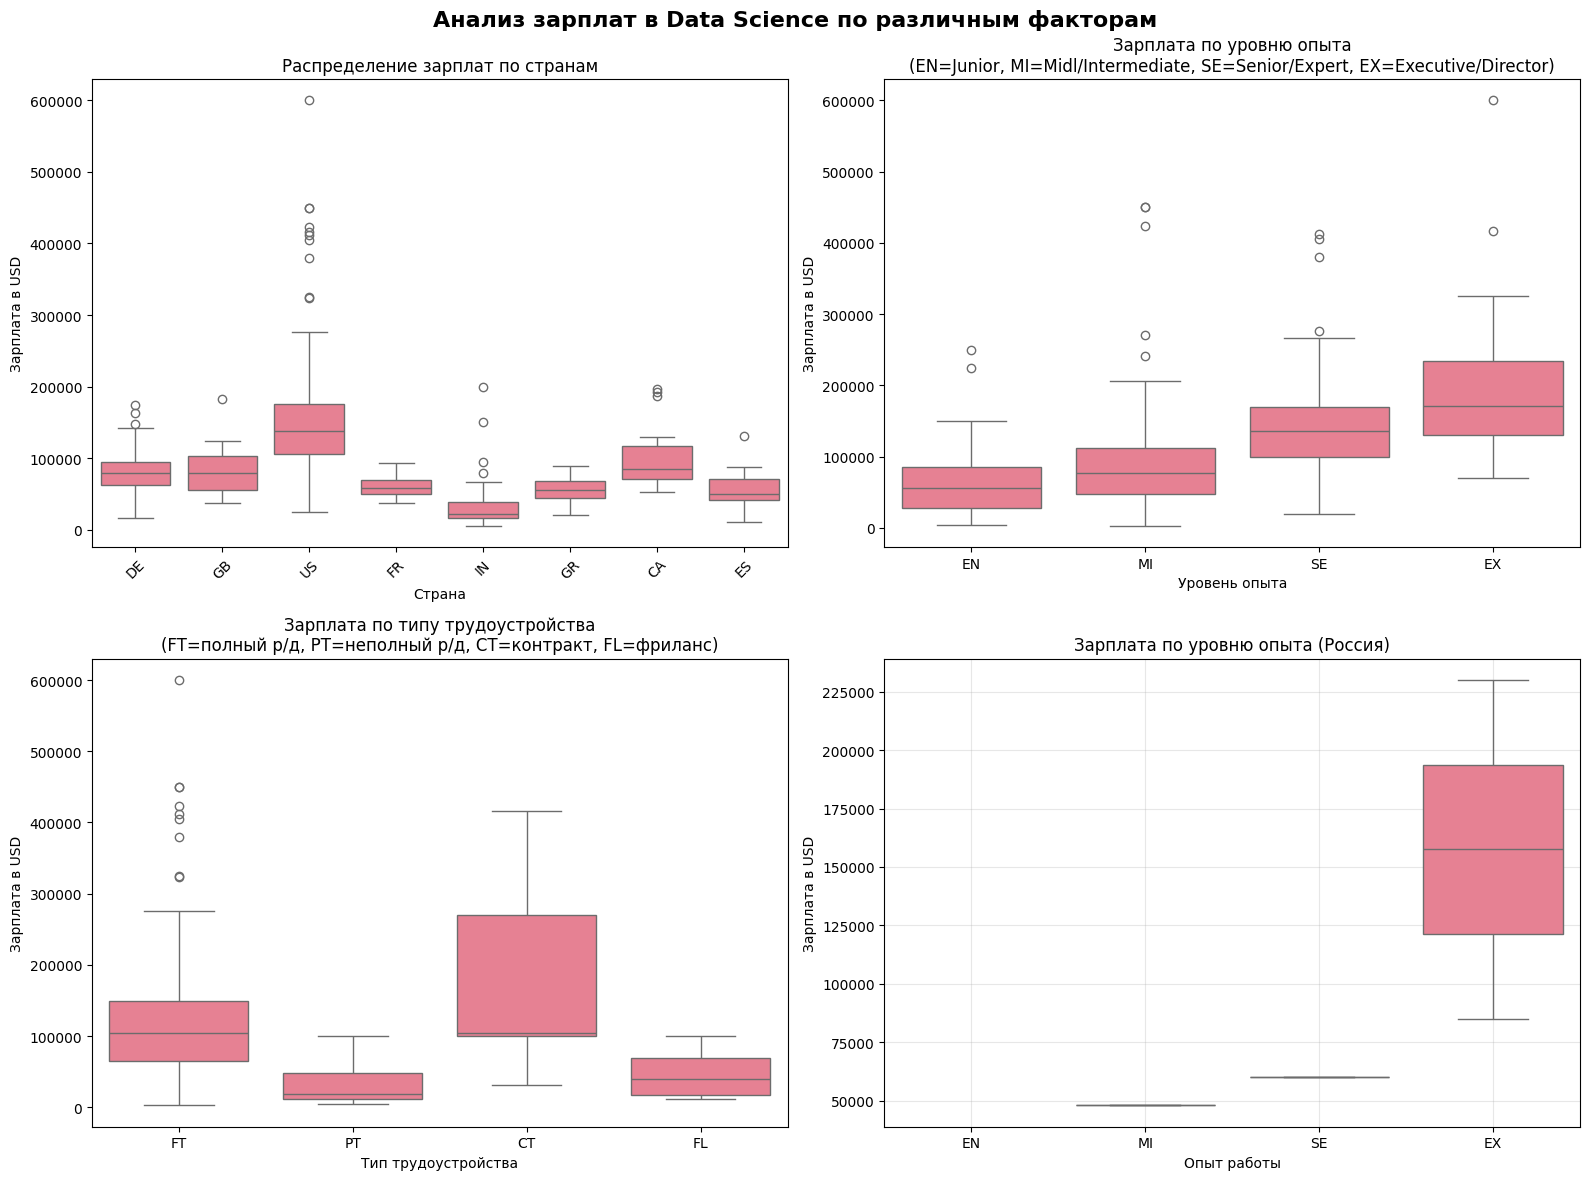

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ зарплат в Data Science по различным факторам', fontsize=16, fontweight='bold')

# 1. Зарплата по странам (топ-8)
top_countries = data['employee_residence'].value_counts().head(8).index
country_data = data[data['employee_residence'].isin(top_countries)]
sns.boxplot(data=country_data, x='employee_residence', y='salary_in_usd', ax=ax1)
ax1.set_title('Распределение зарплат по странам')
ax1.set_xlabel('Страна')
ax1.set_ylabel('Зарплата в USD')
ax1.tick_params(axis='x', rotation=45)

# 2. Зарплата по уровню опыта
experience_order = ['EN', 'MI', 'SE', 'EX']
sns.boxplot(data=data, x='experience_level', y='salary_in_usd', order=experience_order, ax=ax2)
ax2.set_title('Зарплата по уровню опыта\n(EN=Junior, MI=Midl/Intermediate, SE=Senior/Expert, EX=Executive/Director)')
ax2.set_xlabel('Уровень опыта')
ax2.set_ylabel('Зарплата в USD')

# 3. Зарплата по типу трудоустройства
employment_order = ['FT', 'PT', 'CT', 'FL']
sns.boxplot(data=data, x='employment_type', y='salary_in_usd', order=employment_order, ax=ax3)
ax3.set_title('Зарплата по типу трудоустройства\n(FT=полный р/д, PT=неполный р/д, CT=контракт, FL=фриланс)')
ax3.set_xlabel('Тип трудоустройства')
ax3.set_ylabel('Зарплата в USD')

# 4. Зарплата в России по уровню опыта
rus_data = data[data['employee_residence'] == 'RU']
sns.boxplot(data=rus_data, x='experience_level', y='salary_in_usd', order=experience_order, ax=ax4)
ax4.set_title('Зарплата по уровню опыта (Россия)')
ax4.set_xlabel('Опыт работы')
ax4.set_ylabel('Зарплата в USD')

ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()